<a href="https://colab.research.google.com/github/bessx/aniclass/blob/master/AniClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Commands

In [1]:
from keras.applications import xception, vgg16, inception_v3
# from keras.applications.resnet import ResNet101,ResNet152,ResNet50
# from keras.applications.densenet import DenseNet121,DenseNet169,DenseNet201
# from keras.applications.nasnet import NASNetMobile,NASNetLarge

#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential, clone_model
from keras import layers, utils
from keras.layers import Dense, Activation, Flatten, add
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import History, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

Using TensorFlow backend.


# Get Images Files

In [0]:
%%bash
# download tars

wget -nc http://csc.lsu.edu/~bess/aniclass/test.tgz
wget -nc http://csc.lsu.edu/~bess/aniclass/teddy.tgz
wget -nc http://csc.lsu.edu/~bess/aniclass/train100.tgz
wget -nc http://csc.lsu.edu/~bess/aniclass/train1000.tgz
wget -nc http://csc.lsu.edu/~bess/aniclass/train10000.tgz

In [1]:
%%bash
# unpack tars

tar xzvkf test.tgz
tar xzvkf teddy.tgz
tar xzvkf train100.tgz
tar xzvkf train1000.tgz
tar xzvkf train10000.tgz

test/
test/bear/
test/bear/100341460_035cadd922.jpg
test/bear/103342638_58ac74e9c4.jpg
test/bear/1097349227_270b6be93f.jpg
test/bear/1113158099_a8dd12feb1.jpg
test/bear/1165028441_99410b81fe.jpg
test/bear/1165125569_64ffe8b576.jpg
test/bear/1165143673_d712e52bd2.jpg
test/bear/1165943942_c00531e4e3.jpg
test/bear/1165948704_db31fb2034.jpg
test/bear/1165997712_339b4ab7b3.jpg
test/bear/1165998330_611debf6ce.jpg
test/bear/1166006126_193ab6cbd6.jpg
test/bear/1184449431_d8e6701009.jpg
test/bear/1198906327_509c26fa89.jpg
test/bear/1199800468_105b350371.jpg
test/bear/1201038069_5609016e75.jpg
test/bear/1201077289_bb8d444e78.jpg
test/bear/1240636818_eac571137d.jpg
test/bear/1312631232_3b0b883a1a.jpg
test/bear/1355747615_7adca5e952.jpg
test/bear/1392204956_03418e57e9.jpg
test/bear/1405432663_b87d012e9a.jpg
test/bear/1466517370_f527b315ec.jpg
test/bear/1500530822_3c4a8b70ba.jpg
test/bear/155930493_61ca926ba2.jpg
test/bear/160291692_ee1c6d53b0.jpg
test/bear/167630455_387cde5e59.jpg
test/bear/176156

tar: test/bear/100341460_035cadd922.jpg: Cannot open: File exists
tar: test/bear/103342638_58ac74e9c4.jpg: Cannot open: File exists
tar: test/bear/1097349227_270b6be93f.jpg: Cannot open: File exists
tar: test/bear/1113158099_a8dd12feb1.jpg: Cannot open: File exists
tar: test/bear/1165028441_99410b81fe.jpg: Cannot open: File exists
tar: test/bear/1165125569_64ffe8b576.jpg: Cannot open: File exists
tar: test/bear/1165143673_d712e52bd2.jpg: Cannot open: File exists
tar: test/bear/1165943942_c00531e4e3.jpg: Cannot open: File exists
tar: test/bear/1165948704_db31fb2034.jpg: Cannot open: File exists
tar: test/bear/1165997712_339b4ab7b3.jpg: Cannot open: File exists
tar: test/bear/1165998330_611debf6ce.jpg: Cannot open: File exists
tar: test/bear/1166006126_193ab6cbd6.jpg: Cannot open: File exists
tar: test/bear/1184449431_d8e6701009.jpg: Cannot open: File exists
tar: test/bear/1198906327_509c26fa89.jpg: Cannot open: File exists
tar: test/bear/1199800468_105b350371.jpg: Cannot open: File exis

In [0]:
# check for issues
ls -alh

total 176M
drwxr-xr-x  1 root root 4.0K Apr 29 07:23 ./
drwxr-xr-x  1 root root 4.0K Apr 29 07:09 ../
drwxr-xr-x  1 root root 4.0K Apr 27 16:13 .config/
drwxr-xr-x  1 root root 4.0K Apr  3 16:24 sample_data/
drwxrwxrwx 12 root root 4.0K Apr 29 03:59 train100/
-rw-r--r--  1 root root 176M Apr 29 04:08 train100.tgz


# Models Setup

In [0]:
# Import Pre-trained Models and save to /models
# VGG16
# Xception
# InceptionV3

xcept_pre = xception.Xception(include_top=True, weights='imagenet')
xcept_pre.name = 'xcept' 
vgg16_pre = vgg16.VGG16(include_top=True, weights='imagenet')
vgg16_pre.name = 'vgg16' 
incept_pre = inception_v3.InceptionV3(include_top=True, weights='imagenet')
incept_pre.name = 'incept' 

In [23]:
!mkdir models
model_list = [xcept_pre, vgg16_pre, incept_pre]

for mdl in model_list:
  mdl.save('models/' + mdl.name + '_pre.h5')
  print('Saved ' + mdl.name + '_pre to disk')

mkdir: cannot create directory ‘models’: File exists
Saved xcept_pre to disk
Saved vgg16_pre to disk
Saved incept_pre to disk


In [0]:
incept_pre.summary()

In [0]:
# Top Model Block
x = xcept_pre.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

# add your top layer block to your base model
xcept_train = Model(xcept_pre.input, predictions)
print(xcept_train.summary())

ValueError: ignored

In [0]:
print(xcept_train.summary())

NameError: ignored

In [0]:
# Make Untrained VGG16 Clone
# ovgg16_10 = clone_model(vgg16_h5)
# ovgg16_10.set_weights(vgg16_h5.get_weights())
# ovgg16.layers.pop()
# ovgg16.summary()

In [0]:
# ovgg16_input  = vgg16_h5.get_layer(index=0).input
# ovgg16_output = vgg16_h5.get_layer(index=-3).output
# ovgg16_model = Model(inputs=ovgg16_input, outputs=ovgg16_output)

# ovgg16 = Sequential()
# ovgg16.add(ovgg16_model)
# ovgg16.add(Dense(10, activation='softmax', input_dim=4096, name='predictions'))

In [0]:
# CHENG
# x = Dense(10, activation='softmax', name='predictions')(ovgg16.layers[-2].output)
# ovgg16 = Model(input=vgg16_h5.input, output=x)

In [0]:
xcept_pre.summary()

In [3]:
## Freeze all but last two layers of the model
for ind, layer in enumerate(xcept_pre.layers):
  if ind >= (len(xcept_pre.layers)-2):
    layer.trainable = True
    print(ind, layer, "if")
  else: 
    layer.trainable = False
    print(ind, layer, "else")

xcept_pre.summary()

#layer_l1 = model.get_layer('fc2')
#layer_l2 = model.get_layer('predictions')
#layer_l1.trainable=True
#layer_l2.trainable=True

0 <keras.engine.input_layer.InputLayer object at 0x7f97bf1571d0> else
1 <keras.layers.convolutional.Conv2D object at 0x7f977cddccf8> else
2 <keras.layers.normalization.BatchNormalization object at 0x7f977cddcf28> else
3 <keras.layers.core.Activation object at 0x7f977cddcf98> else
4 <keras.layers.convolutional.Conv2D object at 0x7f97db205278> else
5 <keras.layers.normalization.BatchNormalization object at 0x7f97701f1cc0> else
6 <keras.layers.core.Activation object at 0x7f97701f16d8> else
7 <keras.layers.convolutional.SeparableConv2D object at 0x7f97701d2668> else
8 <keras.layers.normalization.BatchNormalization object at 0x7f9770170d68> else
9 <keras.layers.core.Activation object at 0x7f9770197978> else
10 <keras.layers.convolutional.SeparableConv2D object at 0x7f97c88ef710> else
11 <keras.layers.normalization.BatchNormalization object at 0x7f97701379b0> else
12 <keras.layers.convolutional.Conv2D object at 0x7f97701baa58> else
13 <keras.layers.pooling.MaxPooling2D object at 0x7f9770154a

# Retrain Last Layers

In [0]:
model = xcept_pre #@param ["xcept_pre", "incept_pre", "vgg16_pre"] {type:"raw"}
traindir = 'train1000' #@param ["train100", "train1000", "train10000"]

img_height = 299 #@param {type:"integer"}
img_width = 299 #@param {type:"integer"}

batch_size = 50 #@param {type:"integer"}
nb_epochs = 20 #@param {type:"integer"}

In [0]:
!mkdir results

In [0]:
# retrain last 2 layers model

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    traindir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='binary')

# Fix for Corrupt Images
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

# Learning rate is changed to 0.001
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Save accuracy to history
filepath = 'models/' + model.name + '_' + traindir + ".h5"

cblist = [
    History(),
    ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
]

history = model.fit_generator(
    my_gen(train_generator),
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = my_gen(validation_generator), 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=cblist)

# pred = model.predict_generator(test_generator, test_generator.samples // batch_size, verbose=1)
meval = model.evaluate_generator(test_generator, verbose=1)
mev = 'test loss: %.5f - test acc: %.2f%%' % (meval[0], meval[1]*100)
print(mev)
%store meval > models/"$model.name"_"$traindir"_eval.txt
%store mev >> results/"$model.name"_"$traindir"_ev.txt

Found 1615 images belonging to 10 classes.
Found 285 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/20
32/32 [==============================] - 57s 2s/step - loss: 0.5774 - acc: 0.8444 - val_loss: 0.6475 - val_acc: 0.8120

Epoch 00001: val_acc improved from -inf to 0.81200, saving model to models/xcept_train1000.h5
Epoch 2/20
22/32 [===================>..........] - ETA: 12s - loss: 0.5798 - acc: 0.8413

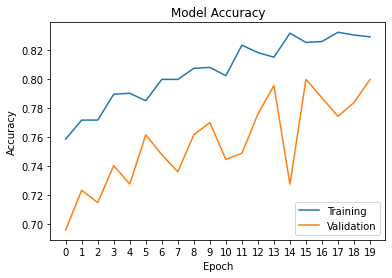

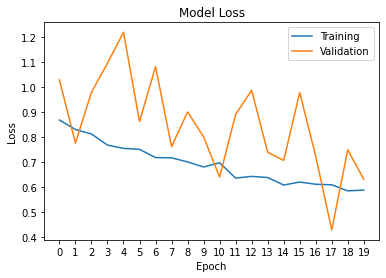

Writing 'history.history' (dict) to file 'results/xcept_train1000_history.txt'.
Writing 'hist_df' (DataFrame) to file 'results/xcept_train1000_histdf.txt'.


In [49]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, nb_epochs))
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('results/' + model.name + "_" + traindir + '_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, nb_epochs))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('results/' + model.name + "_" + traindir + '_loss.png')
plt.show()

# build history dataframe and save
hist_df = pd.DataFrame(history.history)
%store history.history > results/"$model.name"_"$traindir"_history.txt
%store hist_df > results/"$model.name"_"$traindir"_histdf.txt

In [50]:
hist_df

,val_loss,val_acc,loss,acc
0,1.028452,0.696000,0.867882,0.758750
1,0.775751,0.723404,0.830012,0.771885
2,0.979312,0.714894,0.812103,0.771885
3,1.095383,0.740426,0.767560,0.789776
4,1.219381,0.727660,0.754351,0.790415
5,0.861713,0.761702,0.750461,0.785304
6,1.081401,0.748000,0.717495,0.800000
7,0.761133,0.736170,0.716476,0.800000
8,0.900374,0.761702,0.700191,0.807668
9,0.800787,0.770213,0.679820,0.808307


# The following code is for individual image and model tests

In [0]:
# Get Test Images
!wget -nc -q -P example_images/ https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg
!wget -nc -q http://farm1.static.flickr.com/145/430300483_21e993670c.jpg -O example_images/eagle.jpg

In [0]:
# Test Images Individually

# load an image from file
image = load_img('example_images/eagle.jpg', target_size=(224, 224))
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)
features = vgg16_pre.predict(image)

# Print Predictions
print('Predictions:')
preds = decode_predictions(features, top=5)[0]
for p in preds:
  print('%s: %s (%.2f%%)' % (p[0], p[1], p[2]*100))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
import pathlib

# data_dir = utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos', untar=True)

data_dir = pathlib.Path('ImageNetOther/')

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

image_generator = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

test_generator = image_generator.flow_from_directory(directory=str(data_dir),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

# test_gen = datagen.flow_from_directory('/content/drive/My Drive/CSC7333/test/', target_size=(224,224), class_mode='binary')
# test_samples = len(test_gen.filenames)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
print(test_generator.filenames[82])
print(test_generator.filenames[83])

In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()

pred = ovgg16.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

In [0]:
# Print Predictions
print('Predictions:')
preds = decode_predictions(pred, top=5)[0]
for p in preds:
  print('%s: %s (%.2f%%)' % (p[0], p[1], p[2]*100))

In [0]:
#Image processing

# import matplotlib.image as mpimg 
# import matplotlib.pyplot as plt 
# import glob

# image_list = []

# '''
# for filename in glob.glob('ImageNet Animals/folderNameHere'):
#     im = mpimg.imread(filename) 
#     image_list.append(im)
#     plt.figure()
#     plt.imshow(im)
# '''


In [0]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# create generator
# datagen = ImageDataGenerator()

# prepare an iterators for each dataset
# train_gen_100 = datagen.flow_from_directory('train100/', target_size=(299, 299), class_mode='binary') # classes=['11'])
# train_gen_1000 = datagen.flow_from_directory('train1000/', target_size=(224,224), class_mode='binary') # classes=['11'])
# train_gen_10000 = datagen.flow_from_directory('train1000/', target_size=(224,224), class_mode='binary') # classes=['11'])
# test_gen = datagen.flow_from_directory('test/', target_size=(224,224), class_mode='binary') # classes=['11'])

#calculate the length of data
# train_samples_100 = len(train_gen_100.filenames)
# train_samples_1000 = len(train_gen_1000.filenames)
# train_samples_10000 = len(train_gen_10000.filenames)
# test_samples = len(test_gen.filenames)

# train_img=preprocess_input(train_img)

In [0]:

# his = ovgg16_10.fit_generator(my_gen(train_gen), samples_per_epoch=50, epoch=20, validation_split=0.3, callbacks=cblist)
# epochs=20
# history = History()
# history = xcept_pre.fit_generator(my_gen(train_gen_100), samples_per_epoch=100, nb_epoch=epochs, callbacks=[history])